# RSLDS

This part of the list is on RSLDS, for running this you have to install ssm library. It may demand creating fresh environment with `scikit-learn 0.23.1`. In case of problem with installation you can write an email. Some windows users suggested that it is easier to install it with colab/

In [16]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation, find_permutation

## Creating an SLDS and Sampling
Below, we set some parameters for our SLDS: 5 discrete states, latent state of dimension 2, emissions of dimensions 10. We'll be sampling for 100 time bins for the purpose of visualizing the output of our SLDS.

We then create an SLDS object:
```python
true_slds = ssm.SLDS(emissions_dim,
                     n_disc_states,
                     latent_dim,
                     emissions="gaussian_orthog")
```
We specify the emissions model as `"gaussian_orthog"` which ensures that each measurement matrix $C_k$ will be orthogonal. Because an orthogonal matrix is full-rank, this means that our system is fully observable. In other words, the emissions model does not "losing" information about the state.

The syntax for sampling from an SLDS is the same as for an LDS:
```python
states_z, states_x, emissions = true_slds.sample(time_bins)
```
The sample function for SLDS returns a tuple of (discrete states, continuous states, observations).


In [8]:
emissions_dim = 10
n_disc_states = 5
latent_dim = 2
true_slds = ssm.SLDS(emissions_dim,
                     n_disc_states,
                     latent_dim,
                     emissions="gaussian_orthog")

In [9]:
time_bins = 100
states_z, states_x, emissions = true_slds.sample(time_bins)
states_x[:5]


array([[-0.25748182,  0.14790551],
       [ 0.6007441 ,  0.56755209],
       [-1.44896597, -0.82631603],
       [-0.90171617,  0.28992446],
       [ 0.47874294,  1.08396397]])

## Fitting an rSLDS
Below, we create a new rSLDS object and fit it to the data generated above (note that our new rSLDS will only have access to the observations $y$ and not the true states $z$ or $x$). 

### Fitting Methods
During lecture we were talking about bayesian inference and learning in rSLDS models. However most of the implementations of bayesian inference in SLDS are either hard to use and or install or written in R/matlab. That's why we will use methods not presented during the lecture. However I placed the description of Laplace-EM algorithm published by S. Linderman at the end of this notebook. But I don't demand reading it in detail.

**Important Note:**  
 <span style="font-size:larger;">
Understanding the following section is not necessary to use SSM! _For practical purposes, it is almost always best to use the Laplace-EM method with the Structured Mean-Field Posterior, which is the default._ Running the below cells will be a bit slow on a typical laptop (around 5 minutes). We're working on speeding things up in future releases of SSM.
</span>

**Parameter Learning for rSLDS**  
Parameter learning in an rSLDS requires approximate methods. SSM provides two approximate inference algorithms: Black Box Variational Inference (`"bbvi"`) and Laplace Variational EM (`"laplace_em"`). We don't have the space to describe these methods in detail here, but Black Box Variational Inference was described in ["Variational Inference: A Review for Statisticians"](https://arxiv.org/pdf/1601.00670.pdf) by Blei et al. The Laplace Approximation is described in several sources, but a good reference for the context of state-space models is ["Estimating State and Parameters in state-space models of Spike Trains,"](https://pdfs.semanticscholar.org/a71e/bf112cabd47cc67284dc8c12ab7644195d60.pdf) a book chapter by Macke et al.  The specific method used in this notebook is described by ["Zoltowski et al (2020)"](https://arxiv.org/abs/2001.04571).



**Approximate Posterior Distributions**
When using approximate methods, we must choose the form of the distribution we use to approximate the posterior. Here, SSM provides three options:
1. `variational_posterior="meanfield"`
The mean-field approximation uses a factorized distribution as the approximating posterior. Compatible with the BBVI method.

2. `variational_posterior="tridiag"`
This approximates the posterior using a Gaussian with a block tridiagonal covariance matrix, which can be thought of as approximating the SLDS posterior with the posterior from an LDS. Compatible with the BBVI method.

3. `variational_posterior="structured_meanfield"`
This assumes a posterior where the join distribution over the continuous and discrete latent states factors as follows. If $q(z,x \mid y)$ is the joint posterior of the discrete and continuous states given the data, we use the approximation $q(z,x \mid y) \approx q(z \mid y)q(x \mid y)$, where $q(z \mid y)$ is the posterior for a Markov chain. Compatible with the Laplace-EM method.

**Calling the Fit function in SSM**  
All models in SSM share the same general syntax for fitting a model from data. Below, we call the fit function using three different methods and compare convergence. The syntax is as follows:
```python
elbos, posterior = slds.fit(data, method= "...",
                            variational_posterior="...",
                            num_iters= ...)
```
In the the call to `fit`, method should be one of {`"bbvi"`, `"laplace_em"`}.  
The `variational_posterior` argument should be one of {`"mf"`, `"structured_meanfield"`}. However, when using Laplace-EM _only_ structured mean field is supported.


### Getting the Inferred States
For every LDS, SLDS, and rSLDS model in SSM, calling `fit` returns a tuple of `(elbos, posterior)`.  `elbos` is a list containing a lower bound on the log-likelihood of the data at each iteration, used to check the convergence of the fitting algorithm. `posterior` is a posterior object (the exact type depends on which posterior is used). The posterior object is used to get an estimate of the latent variables (in this case $x$ and $z$) for each time step.

Below, we use the line:
```python
xhat_lem = q_lem.mean_continuous_states[0]
```

to get an estimate $\hat x$ of the continuous state over time. The reason for the index `[0]` is that `posterior.mean_continuous_states` will return a list, where each entry is the posterior for a given trial. In this case, we only have a single trial, so we get the first (and only) element of the list.


# Exercise 3 (6 points)
Create an instance of SLDS and RSLDS model, assume that the dimensionality of latent continuous state is equal to 2. Fit them on the data in file `nascar.npy`.
1. Plot the learnt latent trajectories, example below, do you see any significant differences between RSLDS and SLDS? What behavior does the latent state show that could not be captured by a single linear dynamical system?
2. Sample new observations from the learnt models. Plot both the observations and latent space.
3. Let's look again at the form of the discrete state transition probabilities:

$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( \log (P_{j,i}) + w_i^T u_t + r_i ^T x_{t-1} \right)}
$$

In this case, we have used the **recurrent only** transitions class, which means we get rid of the transition matrix and replace it with a bias. Since we don't have any external inputs here, we can also leave out the input terms:


$$
p(z_t = i \mid z_{t-1} = j, x_{t-1}) \propto
\exp{\left( r_i + R_i ^T x_{t-1} \right)}
$$

What happens as the magnitude of the entries in $R_i$ become very large (compared to the entries of $R_j$ for the other states? Do the transitions become more or less random?  

### T1

In [21]:
data = np.load('./nascar.npy')
data[:10]

array([[ 1.40841339, -0.4840931 , -0.39936124, -0.00782327,  0.2925924 ,
         0.27191466,  0.45351639,  1.61444889,  0.98158391,  0.93299438],
       [ 1.36028603, -0.44025859, -0.67904436,  0.16658226,  0.20679616,
         0.55624831,  0.26055941,  1.38775875,  1.13976656,  0.9416085 ],
       [ 1.31607029, -0.39243424, -0.57339457,  0.30153219,  0.240107  ,
         0.49087995,  0.30240626,  1.46266226,  0.99974242,  0.81364441],
       [ 1.55598239, -0.3482002 , -0.76708321,  0.4313717 ,  0.08431196,
         0.47345375,  0.30580299,  1.50917286,  0.91144867,  0.7552753 ],
       [ 1.29573012, -0.35336814, -0.6587763 ,  0.20785146,  0.04043038,
         0.56499995,  0.1755332 ,  1.37490115,  1.06004119,  0.60095823],
       [ 1.42074057, -0.63268517, -0.56513975,  0.19124207,  0.18502015,
         0.75315515,  0.14727121,  1.60166091,  0.98172612,  0.50636696],
       [ 1.48122051, -0.46199408, -0.59441293,  0.29684183, -0.0786988 ,
         0.7297735 ,  0.35801598,  1.27946289

In [122]:
def plot_observations(z, y, ax=None, ls="-", lw=1):
    
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax

def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

In [94]:
T = 10000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [95]:
slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
for k in range(K):
    slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
z, x, y = slds.sample(T)

In [96]:
mask = npr.rand(T, N) < 0.9
y_masked = y * mask

In [97]:
elbos, q_lem = slds.fit(data,masks=mask, method="laplace_em",
                        variational_posterior="structured_meanfield",
                        initialize=False, num_iters=1000)

ELBO: 77000.7: 100%|██████████| 1000/1000 [19:59<00:00,  1.20s/it]


In [98]:
xhat = q_lem.mean_continuous_states[0]
zhat= slds.most_likely_states(xhat, data)


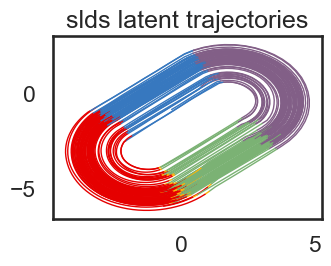

In [99]:
plt.figure(figsize=[10,3])
ax3 = plt.subplot(133)
plot_trajectory(zhat, xhat, ax=ax3)
plt.title("slds latent trajectories")
plt.tight_layout()

In [100]:
D_obs = 10
D_latent = 2

In [102]:
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
# rslds.initialize(y)

In [103]:
rslds_q_elbos, rslds_q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

ELBO: 83550.0: 100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


In [104]:
rslds_xhat = rslds_q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(rslds_xhat, y)))
rslds_zhat = rslds.most_likely_states(rslds_xhat, data)

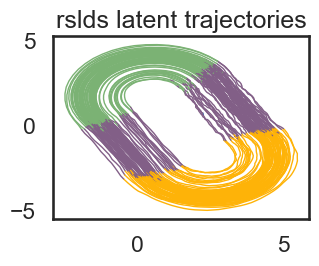

In [105]:
plt.figure(figsize=[10,3])
ax3 = plt.subplot(133)
plot_trajectory(rslds_zhat, rslds_xhat, ax=ax3)
plt.title("rslds latent trajectories")
plt.tight_layout()

### T2 - sample from model

In [134]:
z, x, y = slds.sample(T=T)

In [ ]:
slds_sample_elbos, slds_sample_e_q_lem = slds.fit(y,masks=mask, method="laplace_em",
                        variational_posterior="structured_meanfield",
                        initialize=False, num_iters=1000)

In [ ]:
sample_slds_xhat = slds_sample_e_q_lem.mean_continuous_states[0]
sample_slds_zhat= slds.most_likely_states(sample_slds_xhat, y)

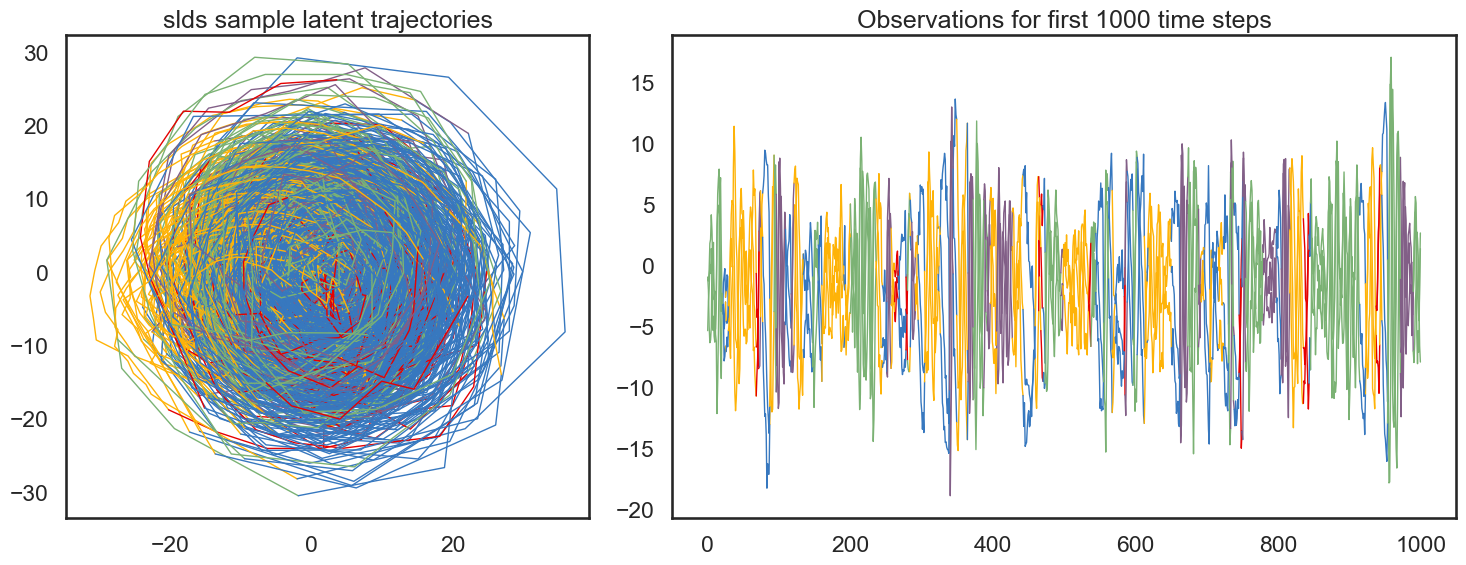

In [137]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(sample_slds_zhat, sample_slds_xhat, ax=ax0)
plt.title("slds sample latent trajectories")

ax1 = plt.subplot(gs[1])
plot_observations(z[:1000], y[:1000,:3], ax=ax1)
plt.title("Observations for first 1000 time steps")
plt.tight_layout()

In [143]:
z_, x_, y_ = rslds.sample(T=T)
rslds.initialize(y_)

In [144]:
rslds_sample_q_elbos, rslds_sample_q_lem = rslds.fit(y_, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

ELBO: 69443.2: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


In [145]:
rslds_sample_xhat = rslds_sample_q_lem.mean_continuous_states[0]
rslds.permute(find_permutation(z_, rslds.most_likely_states(rslds_sample_xhat, y_)))
rslds_sample_zhat= rslds.most_likely_states(rslds_sample_xhat, y_)

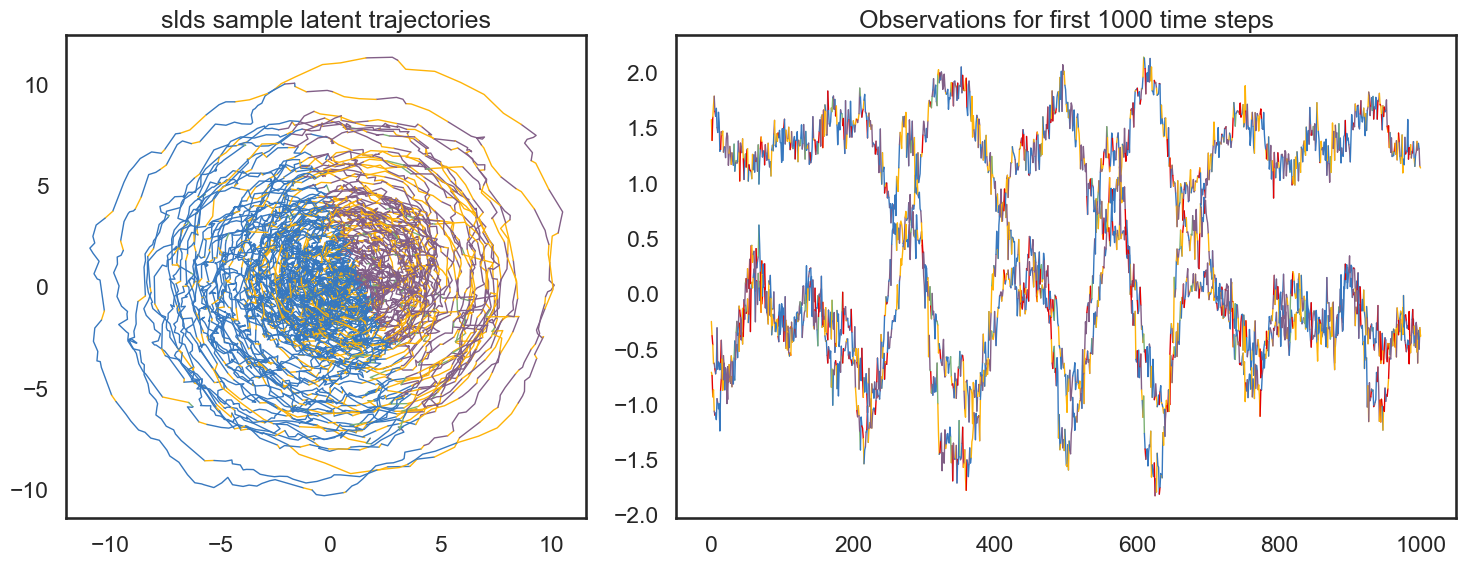

In [146]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])
plot_trajectory(rslds_sample_zhat, rslds_sample_xhat, ax=ax0)
plt.title("slds sample latent trajectories")

ax1 = plt.subplot(gs[1])
plot_observations(z_[:1000], y_[:1000,:3], ax=ax1)
plt.title("Observations for first 1000 time steps")
plt.tight_layout()

# *Variational Laplace-EM

We will fit a switching linear dynamical system (SLDS) to the observed data $y$. Our approach combines variational inference and a Laplace approximation. The objective we maximize is the evidence lower bound (ELBO)

$$ \mathcal{L}_q(\theta) = \mathbb{E}_{q(z) q(x)}[\log p(z,x,y|\theta)] - \mathbb{E}_{q(z)}[\log q(z)] - \mathbb{E}_{q(x)}[\log q(x)] $$

where $\theta$ are the model parameters, $z$ are the discrete latent variables, and $x$ are the continuous latent variables. We introduced an approximate posterior that factorizes over the discrete and continuous latent variables, $p(z, x \, | \, \theta, y) \approx q(z) \, q(x)$. This form of the posterior corresponds to the `variational_posterior="structured_meanfield"` argument in the `fit` method.

The variational Laplace-EM inference method performs three updates at each iteration:
1. Update $q(z)$ using the optimal coordinate ascent variational inference update
2. Update $q(x)$ using a Laplace approximation at the most likely latent path (note that this step is not guaranteed to increase the ELBO)
3. Update $\theta$ by optimizing the ELBO with respect to the model parameters

You can initialize a variational posterior and fit the model by running the function
```
# Fit the model using Laplace-EM with a structured variational posterior
elbos, q_lem = slds.fit(data, inputs, masks, method="laplace_em",
                        variational_posterior="structured_meanfield",
                        initialize=False, num_iters=100)
```
The output variables are the values of the objective at each iteration `elbos` and the variational posterior object `q_lem`. If you have already initialized a variational posterior object, you can pass that object as the argument of the `variational_posterior` parameter instead. Here, the `initialize` parameter was set to `False`, which assumes we have already initialized the model. Additionally, note that in `fit` you can also pass in keyword arguments for initialization of the variational posterior. 

In [ ]:
elbos, q_lem = slds.fit(data, inputs, masks, method="laplace_em",
                        variational_posterior="structured_meanfield",
                        initialize=False, num_iters=100)

### Hyperparameters
There are a number of hyperparameters that can be used when fitting with `laplace_em`. These include generic hyperparameters:
- `num_iters` - the number of iterations to run (default = 100)
- `learning` - optimize the model parameters when True (default = True)
    
Discrete state hyperparameters:
- `num_samples` - number of Monte Carlo samples (default = 1) used for evaluating expectations with respect to $q(x)$ in the update for $q(z)$

Continuous state hyperparameters:
- `continuous_optimizer`, `continuous_tolerance`, `continuous_maxiter` specify parameters of the optimization for finding the most likely latent path in the continuous latent update. We recommend using the default optimizer Newton's method (`newton`) to compute the most likely latent path. However, Hessian-free optimization is supported with `lbfgs`. The tolerance and maxiter parameters can be adjusted for the user's requirements. 

Model parameter update hyperparameters:
- `alpha` - parameter in $[0,1)$ with default $0.5$ that determines how greedy we are in updating the model parameters at each iteration. This is only used in conjunction with `parameters_update="mstep"`. 
- `parameters_update` - the model parameter updates are implemented via an m-step given a single sample from $q(x)$ (default, `"mstep"`) or whether using SGD with samples from $q(x)$ (`"sgd"`).
- `emission_optimizer` - the optimizer used to update parameters in the m-step. This defaults to the `adam` optimizer when using the `"sgd"` parameter updates. 
- `emission_optimizer_maxiter` - the maximum number of iterations for the inner loop of optimizing the emissions parameters. 